In [53]:
import random
import pygame
import time
import math
from math import exp, sqrt
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import imageio.v2 as imageio

In [4]:
def distance(x1, y1, x2, y2):
    return sqrt( (x2-x1)**2 + (y2-y1)**2)

In [47]:
class Objects(pygame.sprite.Sprite):
    def __init__(self, world, coord):
        super(Objects, self).__init__()
        pygame.sprite.Sprite.__init__(self)
        self.world = world
        self.birth_place = coord
        
    def generate_object(self, object_type, size):
        #self.Typo = object_type
        self.x = self.birth_place[0]
        self.y = self.birth_place[1]
        self.size = size
        self.width = int(self.size[0] * self.world.proportion )
        self.height = int(self.size[1] * self.world.proportion )
        
        image = f"images/{object_type}.png" # <------------------
        self.Image0 = pygame.image.load(image)
        self.Image = pygame.transform.scale(self.Image0, (self.width, self.height))
        self.rect = pygame.rect.Rect((self.x, self.y, self.width, self.height))
        self.rect.center = (self.x, self.y)
    
        
    # refine this
    def is_eaten_from(self, obj):
        obj.survive = True
              
        obj.score =1     
        self.alive = False
        
    def check_energy(self):
        if self.energy <= 0:
            self.alive = False
            
    def get_position(self):
        return self.x, self.y

class Animal(Objects):# has World class as an input and the coordinate of the object in that world
    def __init__(self, world, coord ):
        super(Animal,self).__init__(world, coord)
        
        
        self.interval = 2  
        self.size_animal = ( 160, 240) # this for window size
        self.world = world
       
        self.initial_energy = 2000
        self.energy = self.initial_energy
        self.Size = 1
       # self.speed = 1
        self.vision = 30
        self.energy_lose = self.Size**3 * self.speed**2 + self.vision/30
        self.period = time.time()
             
        self.alive = True
        self.survive = False
        self.attention = False
        self.score = 0
           
        self.attention_spot = random_attention()
        self.attention_spot.x = random.random() * 500
        self.attention_spot.y = random.random() * 500
        self.obj_attention = {"food":None, "predator":None, "mate":None}
        
        self.generate_object(self.type, self.size_animal)
        
        
    def update(self, world, objs):
        neighbors = self.neighbors(objs)
        self.update_animal()
        self.explore()
        if self.score < 2:
            self.act(neighbors)
            self.check_encounter(world, objs)
            self.check_energy()
        else:
            self.go_home()
        
            
       # self.check_energy()
    
        
    def neighbors(self, objs):
        return [obj for obj in objs if distance(self.x, self.y, obj.x, obj.y) <=self.vision and id(self)!=id(obj)]
    
    def update_animal(self):
        self.attention = False
        self.update_sight()
        self.explore() if random.random() <= 0.0001 else None
        self.energy -= self.energy_lose
        
    def explore(self):
        if np.sqrt((self.attention_spot.x-self.x)**2 + (self.attention_spot.y - self.y)**2) < 10:
            self.attention_spot.x = self.world.world_width *random.uniform(0,1)
            self.attention_spot.y = self.world.world_height *random.uniform(0,1)
        
    def act(self, objs):
        obj_distance = {"predator": math.inf, "food": math.inf, "mate": math.inf}
        flag = 0
        
        for obj in objs:
            dist = distance(self.x, self.y, obj.x, obj.y)
            in_sight = dist <= self.vision
            
            if in_sight:
                if isinstance(obj, Animal):
                   # print(type(self))
                    obj_is_predator = type(self) is Gazelle and type(obj) is Lion and self.Size/obj.Size <=1.2
                    
                    obj_is_food     = type(self) is Lion and type(obj) is Gazelle and obj.Size/self.Size <=1.2 and self.score == 0
                    obj_is_mate     = (type(self) is type(obj)) and (self.sex != obj.sex) and (time.time()-self.period>self.interval) and self.score == 1 and obj.score == 1
                    if obj_is_predator and dist<=obj_distance["predator"] and id(self)!=id(obj):
                       # print("l1")
                        obj_distance["predator"] = dist
                        self.attention_on(obj, "predator")
                        flag += 1
                        
                    
                    elif obj_is_food and dist <= obj_distance["food"] and id(self)!=id(obj):
                       
                        obj_distance["food"] = dist
                        self.attention_on(obj, "food")
                        flag += 1
                        
                    elif obj_is_mate and dist <= obj_distance["mate"] and id(self)!=id(obj):
                        obj_distance["mate"] = dist
                        self.attention_on(obj, "mate")
                        flag += 1
                ###############################################################
                elif  isinstance(self, Gazelle) and isinstance(obj, Grass) and dist <= obj_distance["food"] and id(self)!=id(obj) and self.score==0:
                  
                    obj_distance["food"] = dist
                    self.attention_on(obj, "food")
                    flag += 1
                    
        priority = min([obj_distance["food"],obj_distance["mate"],obj_distance["predator"]])
        if flag:
            if priority == obj_distance["predator"]:
                location = self.obj_attention["predator"]
                if location is not None:
                    self.attention_spot.x = location[0]
                    self.attention_spot.y = location[1]
                    self.reverse_direction()
                    
            elif priority == obj_distance["food"]:
                location = self.obj_attention["food"]
                if location is not None:
                    self.attention_spot.x = location[0]
                    self.attention_spot.y = location[1]
                    
            # put a condition on this priority
            elif priority == obj_distance["mate"]:
                location = self.obj_attention["mate"]
                if location is not None:
                    self.attention_spot.x = location[0]
                    self.attention_spot.y = location[1]
        else:
            self.explore()
                    
        self.move()
                    
    def attention_on(self, obj, Type):
        self.obj_attention[Type] = (obj.x, obj.y)
        self.attention = True
        
    def reverse_direction(self):
        self.attention_spot.x = self.x + (self.x - self.attention_spot.x)
        self.attention_spot.y = self.y + (self.y - self.attention_spot.y)
        
    def attention_direction(self):
        d = np.subtract((self.attention_spot.x, self.attention_spot.y),(self.x, self.y))
        if np.linalg.norm(d)>0:
            d = d/np.linalg.norm(d)
        else:
            pass
        return d*self.speed
    def go_home(self):
        
        self.attention_spot.x = self.birth_place[0]
        self.attention_spot.y = self.birth_place[1]
      
        self.move()
    
    def move(self):
        dx = self.attention_direction()[0]
        dy = self.attention_direction()[1]
        
        self.x = (dx + self.x)%self.world.world_width
        self.y = (dy + self.y)%self.world.world_height
        """
        if isinstance(self,Gazelle):
            if self.x >= self.world.world_width or self.x <= 0:
                self.x -= 2*dx
                self.reverse_direction()
            elif self.y >= self.world.world_height or self.y <=0:
                self.y -= 2*dy
                self.reverse_direction()
        """
        """
        if isinstance(self,Lion):
            if self.x >= 450 or self.x <= 50:
                self.x -= 2*dx
                self.reverse_direction()
            elif self.y >= 450 or self.y <= 50:
                self.y -= 2*dy
                self.reverse_direction()
        """
        self.rect.center = (self.x, self.y)
        
    def update_sight(self):
        for obj_name in self.obj_attention.keys():
            location = self.obj_attention[obj_name]
            if location is not None and distance(self.x, self.y, location[0], location[1]) <= self.vision:
                self.obj_attention[obj_name] = None
                
    def check_encounter(self, world, objs):
        for obj in objs:
            if self.rect.colliderect(obj):
                if type(obj) is Grass and type(self) is Gazelle and self.score == 0:
                    obj.is_eaten_from(self)
                    
                elif type(obj) is Gazelle and type(self) is Lion and obj.Size/self.Size <= 1.2 :
                    obj.is_eaten_from(self)
                    
                elif type(obj) == type(self) and self.sex != obj.sex and self.sex == "male" and (time.time()-self.period>self.interval) and self.score ==1:
                    world.children += self.reproduce(obj)
                    self.period = time.time()
                    obj.period = time.time()
                    obj.score = 2
                    self.score = 2
                    
    def reproduce(self, obj):
        
            
        children = []
        for i in range(self.children_number):
            child = type(self)(self.world, (self.x, self.y - (self.width + 5))) #<- sex should be random
            speed_mutate    = random.uniform(0.9,1.1)
            vision_mutate   = random.uniform(0.9,1.1)
            size_mutate     = random.uniform(0.9,1.1)
        #increment = energy_reDistibution(energy_percentage) - energy_reDistibution(energy_percentage)
            child.speed = (self.speed + obj.speed)/2  * speed_mutate 
            child.vision = (self.vision+ obj.vision)/2 * vision_mutate
            child.Size  = (self.Size+obj.Size)/2   * size_mutate
            child.width = (self.width + obj.width)/2   * size_mutate#+ increment[2] *self.size_scaling
            child.height = (self.height+obj.height)/2 * size_mutate#
            if isinstance(self, Gazelle):
                child.birth_place = self.birth_place
        
            child.Image = pygame.transform.scale(child.Image0, (child.width, child.height))
            child.rect = pygame.rect.Rect((child.x, child.y, child.width, child.height))
            children.append(child)
        
            
        
        return children
        
# Todo: reproduce, mutate, modify energy, last: put the game loop in a larger loop where all go to boundary
        
class Lion(Animal):
    def __init__(self, world, coord):
        self.children_number = 1
        #self.sexs = ["male", "female"]
        #self.sex = random.choice(self.sexs)
        self.sex = "female" if random.random()<0.5 else "male"
        self.type = "Lion"
        self.speed = 1
        super(Lion, self).__init__(world, coord)
        
        
class Gazelle(Animal):
    def __init__(self, world, coord):
        self.children_number = 2
        #self.sexs = ["male", "female"]
        #self.sex = random.choice(self.sexs)
        self.sex = "female" if random.random()<0.5 else "male"
        self.type = "Gazelle"
        self.speed = 1
        super(Gazelle,self).__init__(world, coord)
        


class random_attention:
    x = -1
    y = -1
    
class Grass(Objects):
    def __init__(self, world, coord):
        super(Grass, self).__init__(world, coord)
        self.type = "Grass"
        self.size_apple = (64,80)
        self.Size = 1
        self.generate_object(self.type, self.size_apple)
        self.alive = True
    def update(self):
        pass
        

class World:
    def __init__(self, world):
        self.world_width = world[0]
        self.world_height = world[1]
        self.proportion = 0.1
        self.width_num = 50
        self.height_num = 50
        self.width_PortionSize = math.ceil(self.world_width/self.width_num)
        self.height_PortionSize = math.ceil(self.world_height/self.height_num)
        self.animal = Animal.__subclasses__()
        self.children = []
        
        self.color = []
        self.coord = 0
        self.last_walk = 0
        self.x = 0
        self.y = 0
        
    def generate_objects(self, object_types=None):
        self.fill_landscape()
        objects=[]
        for obj in object_types.keys():
            if obj == Grass:
                for grass in range(object_types[obj]):
                    objects.append(self.generate_Grass())
                    
            elif obj == Gazelle:
                for i in range(object_types[obj]):
                    
                    X_Y = self.Gazelle_boundary()          
                    objects += [ obj(self, X_Y ) ]
            elif obj == Lion:
                for i in range(object_types[obj]):
                    
                    X_Y = self.Lion_boundary()            
                    objects += [ obj(self, X_Y ) ]
                

        return objects
    
    def fill_landscape(self):
        for row in range(self.width_num):
            for col in range(self.height_num):
                self.color.append( (random.randint(75, 90), random.randint(110, 120), random.randint(40, 50)) )
                
        
    def generate_Grass(self):
        return Grass(self, (self.world_width*random.random(),
                            self.world_height * random.random()))
    def generate_Lion(self):
        return Lion(self, (self.world_width*random.random(),
                            self.world_height * random.random()))
    
    def update(self, world_objects):
        for obj in world_objects:
            if isinstance(obj, Grass):
                obj.update()
            else:
                obj.update(self, world_objects)
          
        
        world_objects = [obj for obj in world_objects if obj.alive]  
       # if random.random() <= 0.01:
        #    world_objects.append(self.generate_Grass())
        
        world_objects += self.children
        #for i in range(5):
        self.children = []
            
            
        return world_objects
    def new_day(self, world_objects, object_types ):
        world_objects = [obj for obj in world_objects if (isinstance(obj,Gazelle ) and obj.alive and obj.survive )]
        #replicas = []
        for obj in world_objects:
            #if isinstance(obj, Gazelle):
                
                
                
            X_Y = self.Gazelle_boundary()
            obj.x = X_Y[0]
            obj.y = X_Y[1]
            obj.energy = obj.initial_energy
            obj.score = 0
            obj.attention = False
            obj.survive = False
            
         
        for grass in range(object_types[Grass]):
            world_objects.append(self.generate_Grass())
            
        for grass in range(object_types[Lion]):
            world_objects.append(self.generate_Lion())
                
                                         
        return world_objects 
    def Gazelle_boundary(self):
        left_bound   = (1                                      ,       self.world_height *random.random())
        right_bound  = (self.world_width-self.width_PortionSize,       self.world_height *random.random())
        upper_bound  = (self.world_width *random.random()      ,                                        1)
        lower_bound  = (self.world_width *random.random()      ,self.world_height-self.height_PortionSize)
        boundary = [ upper_bound, lower_bound, left_bound, right_bound]
        X_Y = random.choice(boundary)
        return X_Y
    def Lion_boundary(self):
        left_bound   = (200                                     ,      200 + 100*random.random())
        right_bound  = (300                                     ,      200 + 100*random.random())
        upper_bound  = (200 + 100*random.random()               ,                            200)
        lower_bound  = (200 + 100*random.random()               ,                            300)
        boundary = [ upper_bound, lower_bound, left_bound, right_bound]
        X_Y = random.choice(boundary)
        return X_Y
        
            
            
    
            
       
                    
class EcoSystem:
    def __init__(self, world_width, world_height):
        self.w = world_width
        self.h = world_height
        super(EcoSystem,self).__init__()
        num_Grass = 35
        num_Lion = 4
        num_Gazelle = 16
        
        self.object_types = {Grass: num_Grass, Lion: num_Lion, Gazelle: num_Gazelle}
        
        self.eco_system = None
        self.popSize_time = dict()
        self.iteration = 0
        self.system_objects = None
        
        self.activate()
        
    def activate(self):
        self.eco_system = World((self.w, self.h))
        self.system_objects = self.eco_system.generate_objects(object_types=self.object_types)
        
        
    def update(self, iterations):
        #eco_system is a world with object and updating the system implies updating the objects of its world
        #self.system_objects = self.eco_system.update(self.system_objects)
        
        one_day_passed = ((iterations+1) %1000 == 0)
        #eco_system is a world with object and updating the system implies updating the objects of its world
        if one_day_passed:
            self.system_objects = self.eco_system.new_day(self.system_objects,object_types=self.object_types)
            self.system_objects = self.eco_system.update(self.system_objects)
        else:
            self.system_objects = self.eco_system.update(self.system_objects)
        
        
        
        
        

In [48]:
world_width, world_height = (500,500)#window.get_size()

display_world = True


animal_world = EcoSystem(world_width, world_height)
iteration = 0
size = []
speed= []
vision=[]
total_days=100
total_iterations=total_days*1000
pbar = tqdm(total = total_days)
while iteration<total_iterations:
    if iteration%1000==0:
        size_tmp=np.array([])
        speed_tmp=np.array([])
        vision_tmp=np.array([])
        for obj in animal_world.system_objects:
            if isinstance(obj, Gazelle):
                size_tmp = np.append(size_tmp,obj.Size)
                speed_tmp = np.append(speed_tmp,obj.speed)
                vision_tmp = np.append(vision_tmp,obj.vision)
        size.append(size_tmp)
        speed.append(speed_tmp)
        vision.append(vision_tmp)
        pbar.update(1)
    animal_world.update(iteration)
    Day = "Day: "+ f"{int(iteration/1000 + 1)}"
    iteration += 1

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [21:27<00:00, 15.12s/it]

In [ ]:
######################################################################################################################

In [ ]:
##################################################################################################################

C:\Users\irena\AppData\Local\Temp\ipykernel_22828\1120048955.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


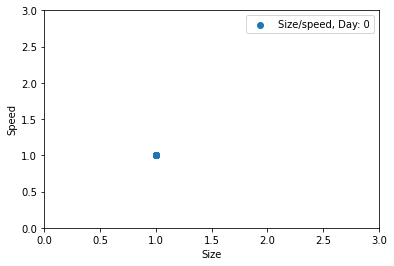

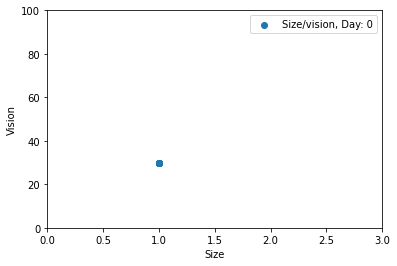

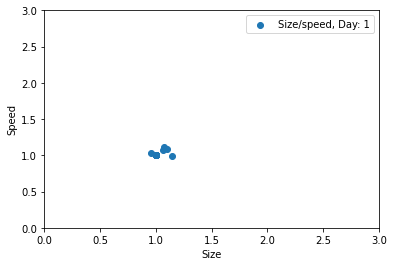

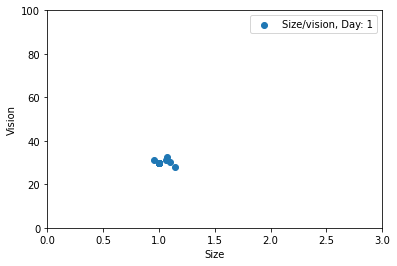

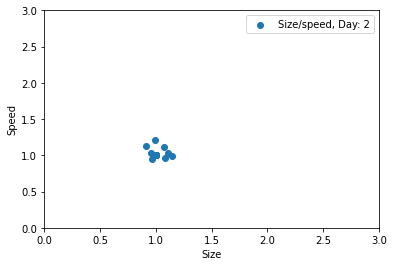

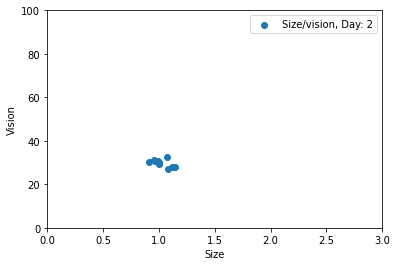

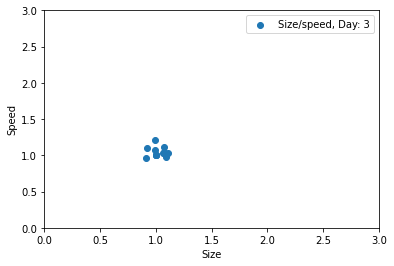

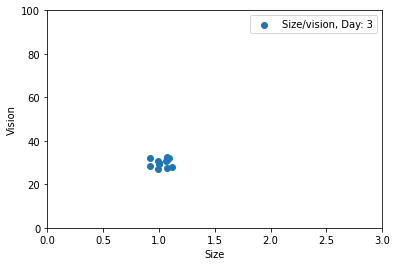

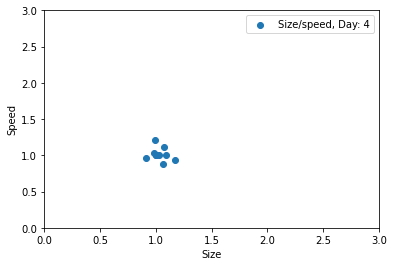

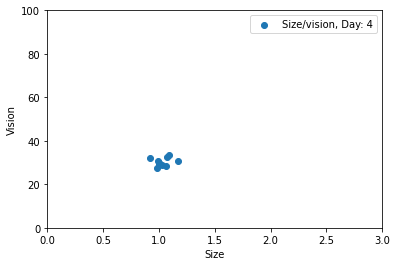

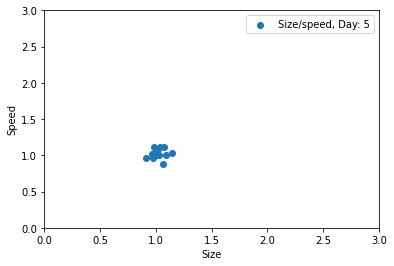

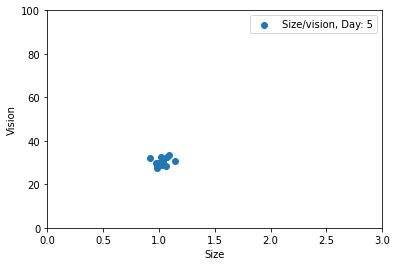

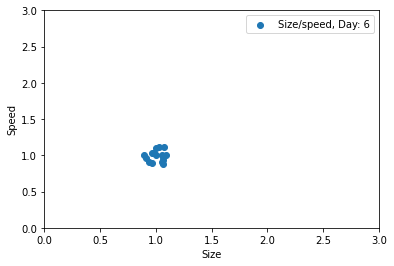

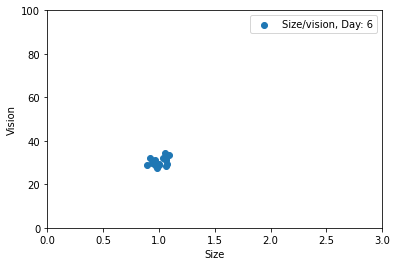

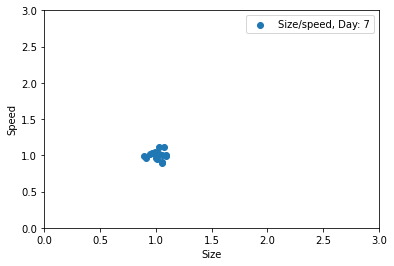

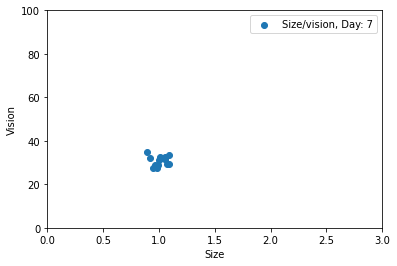

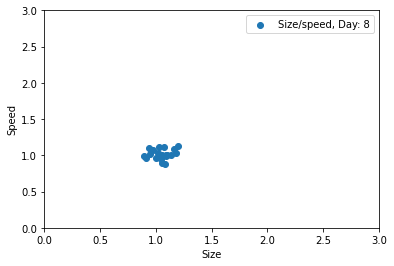

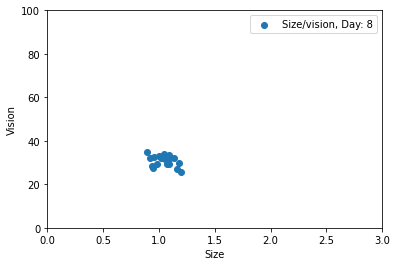

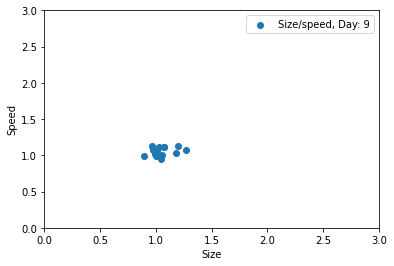

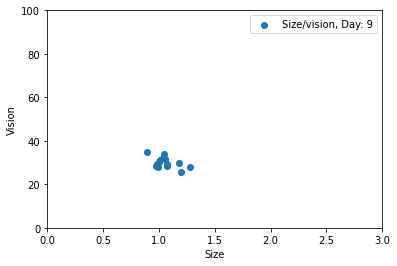

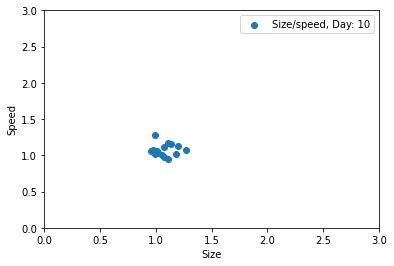

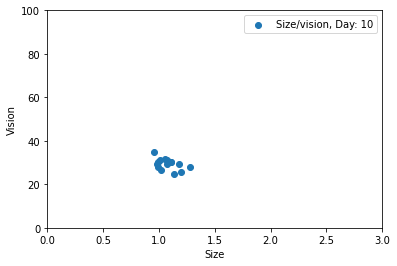

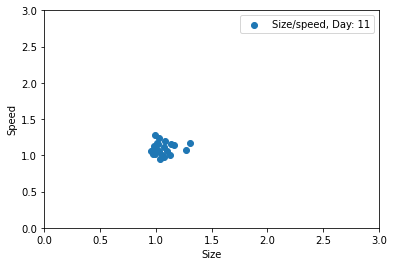

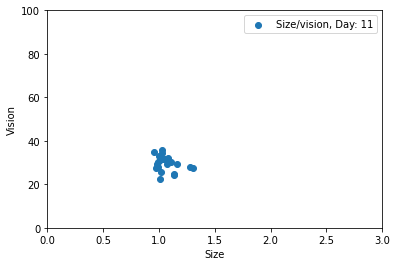

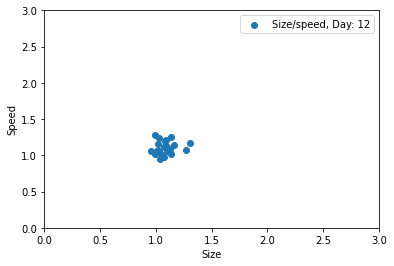

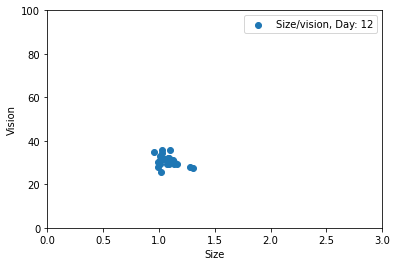

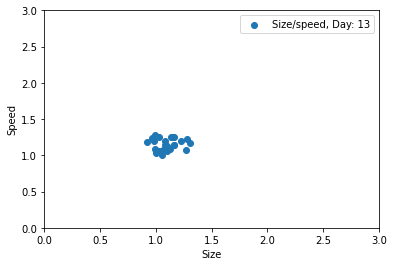

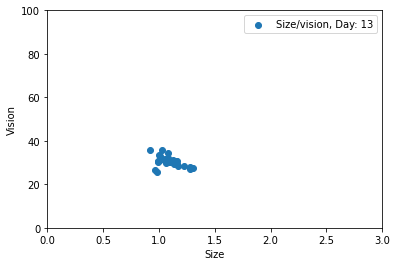

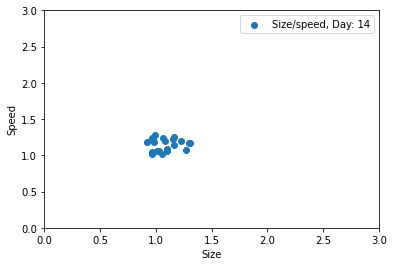

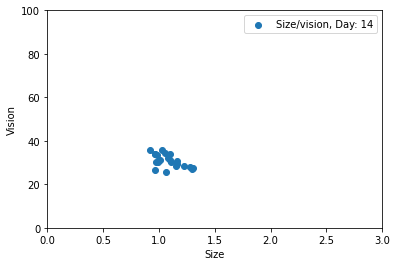

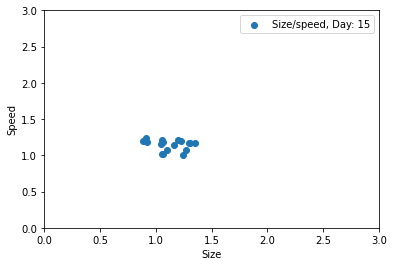

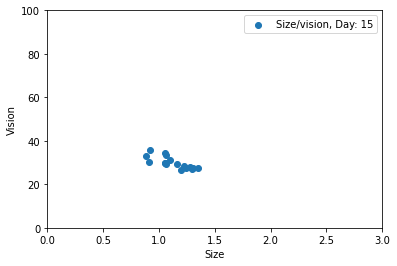

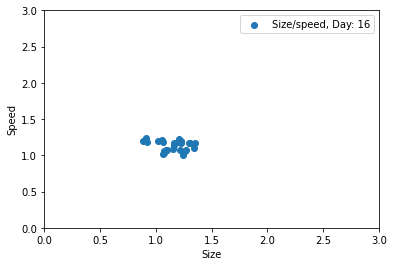

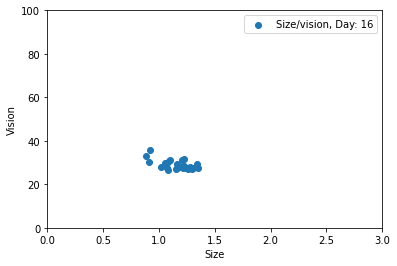

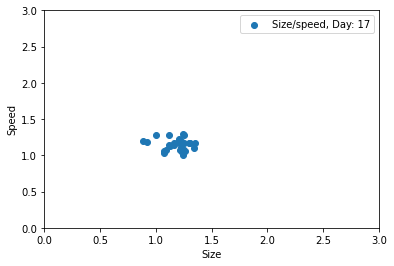

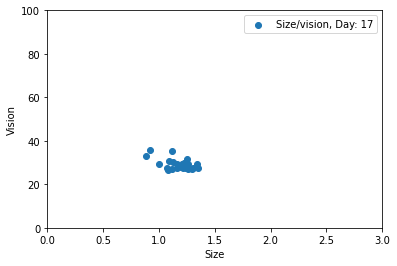

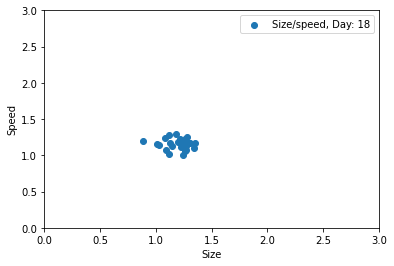

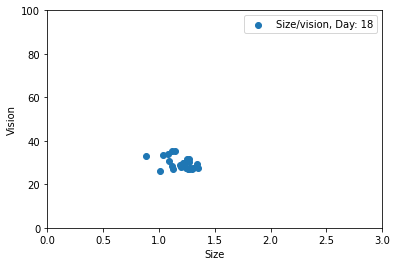

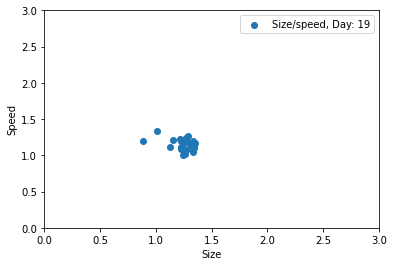

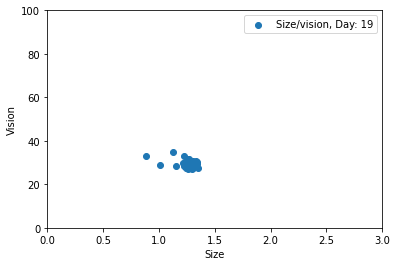

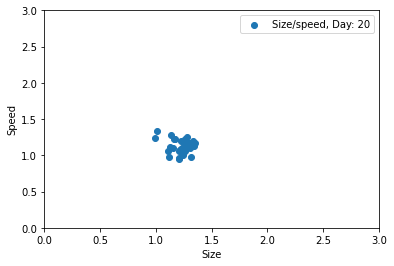

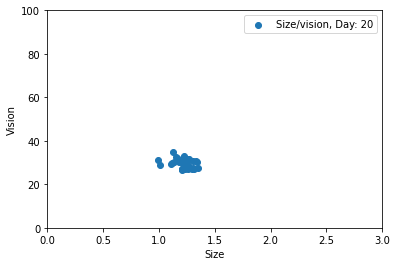

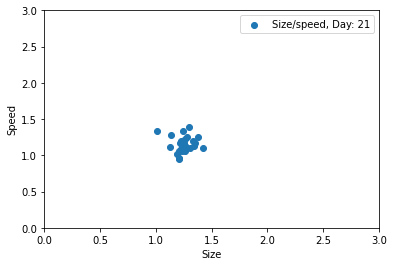

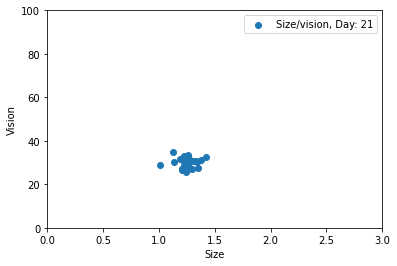

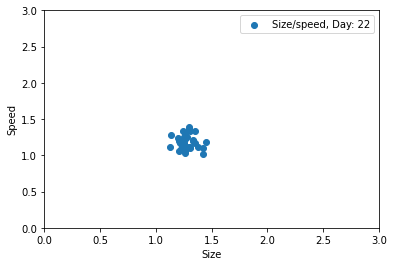

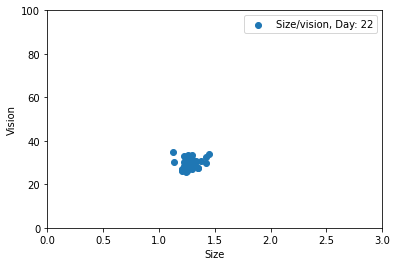

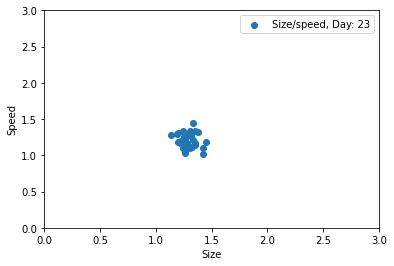

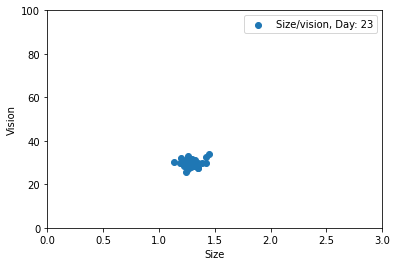

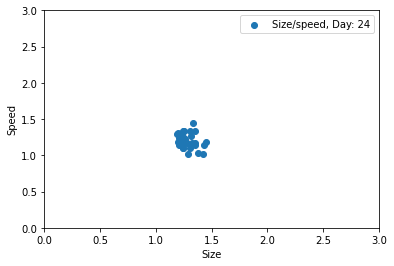

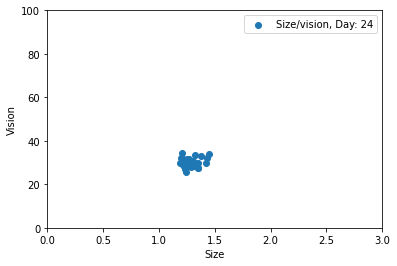

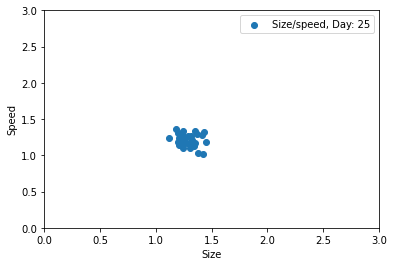

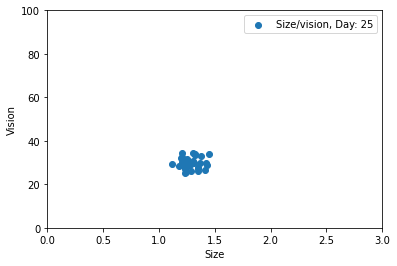

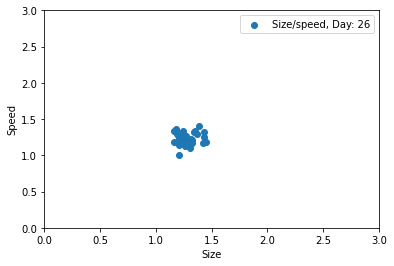

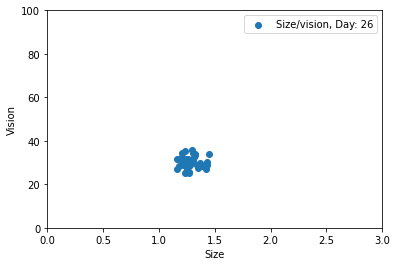

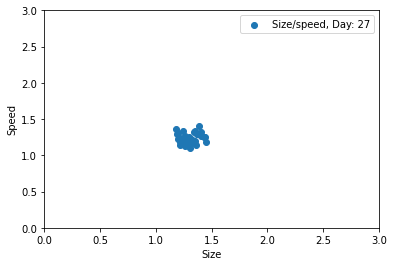

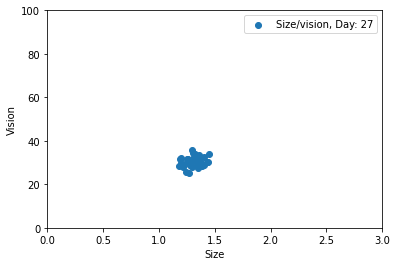

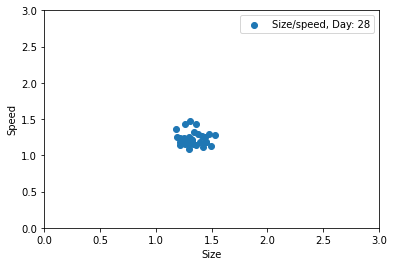

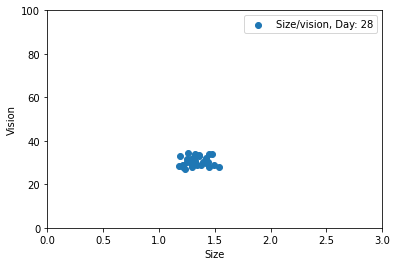

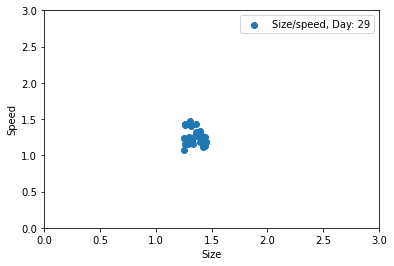

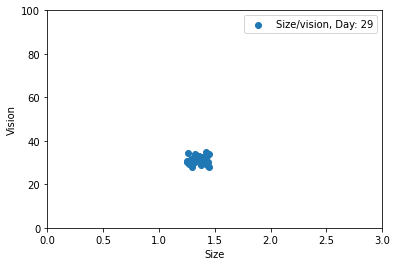

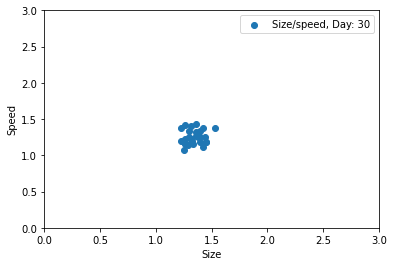

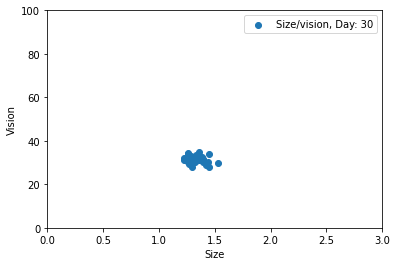

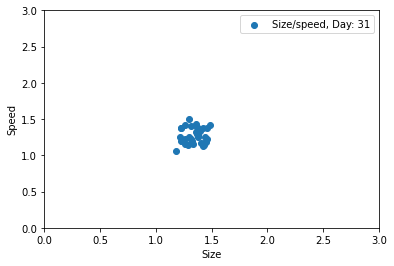

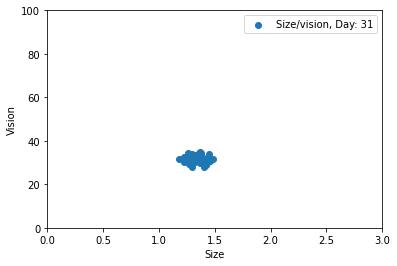

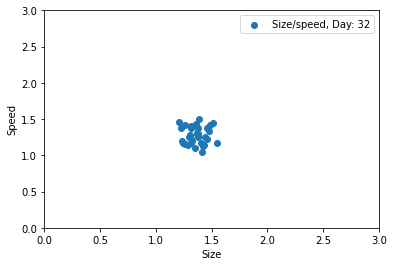

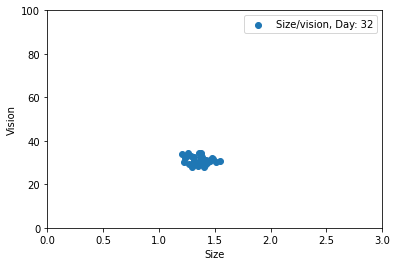

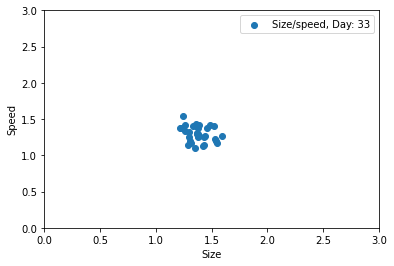

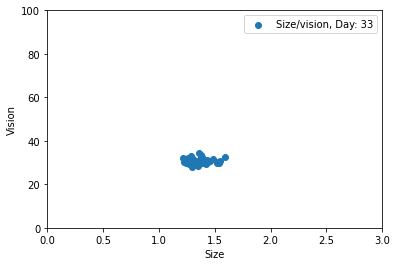

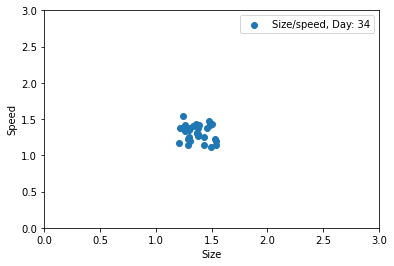

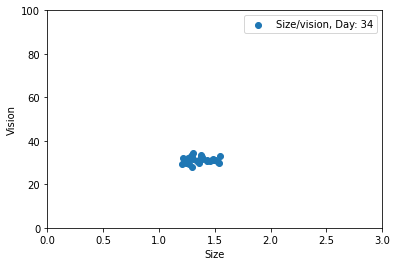

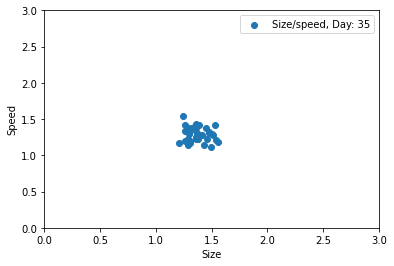

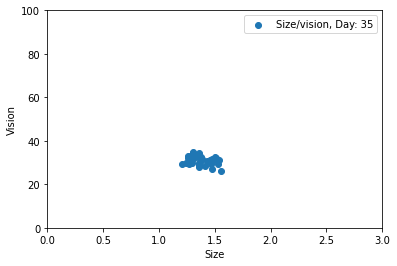

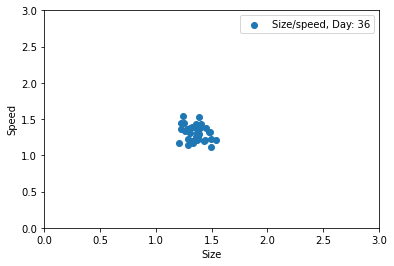

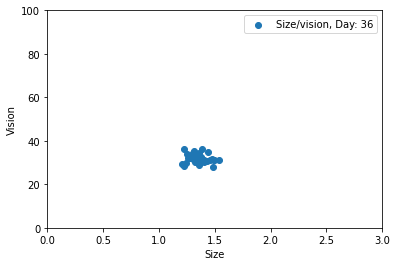

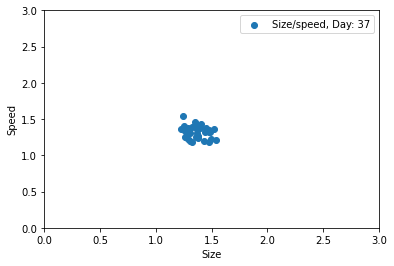

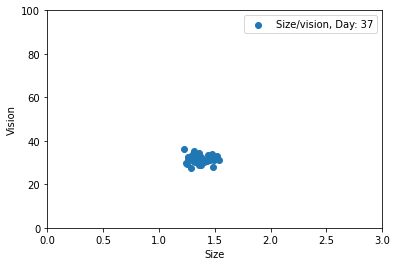

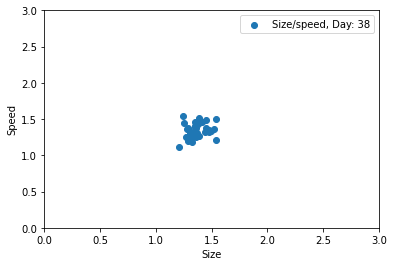

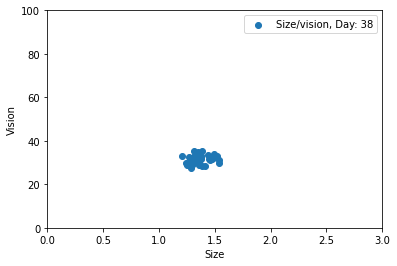

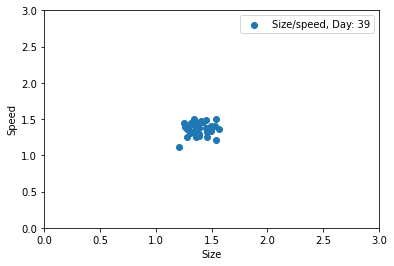

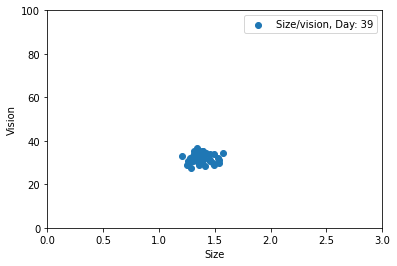

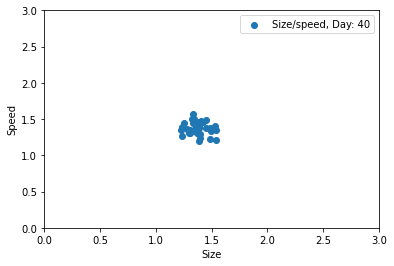

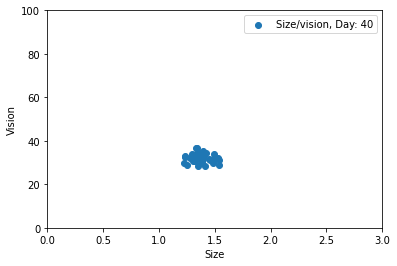

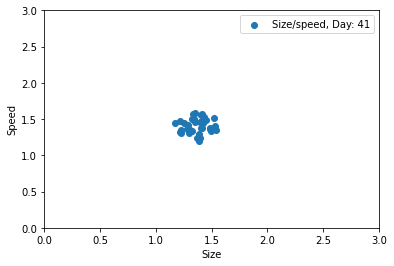

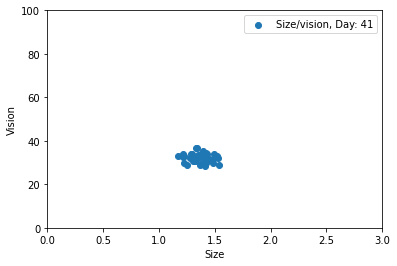

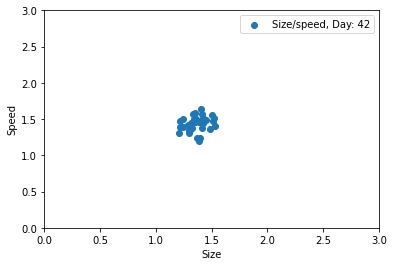

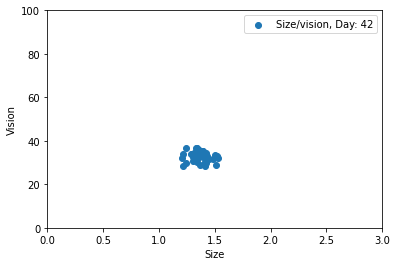

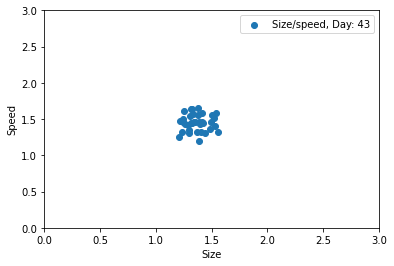

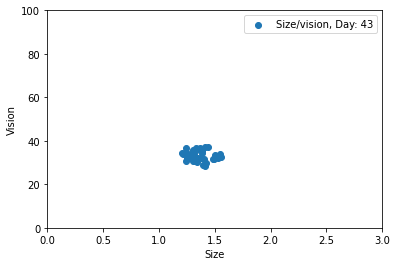

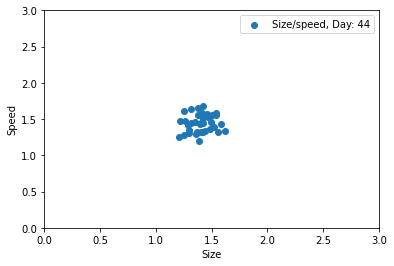

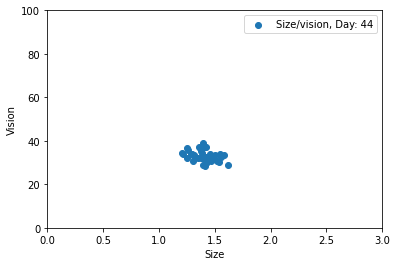

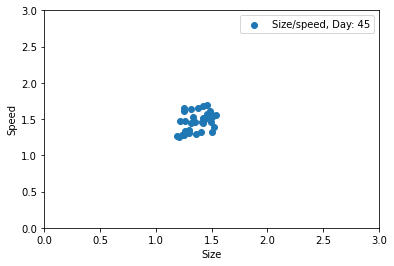

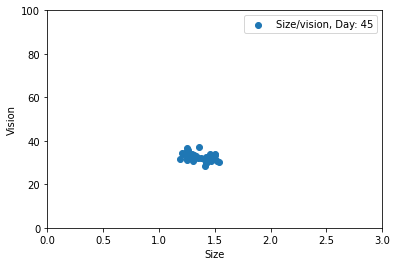

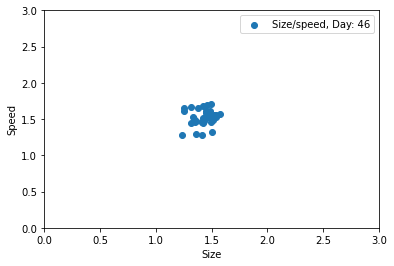

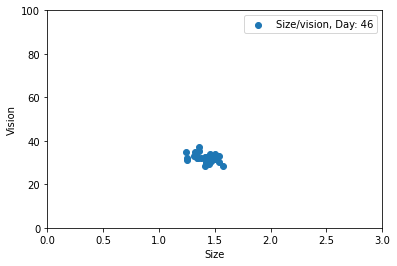

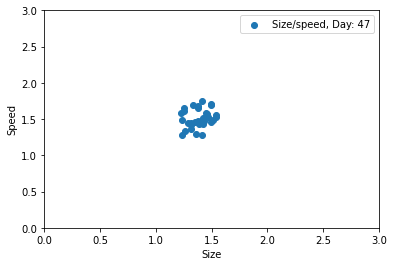

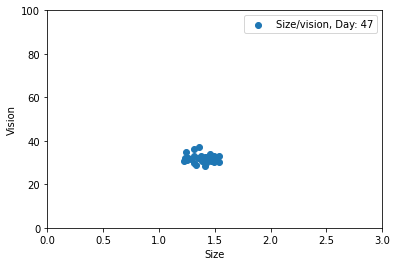

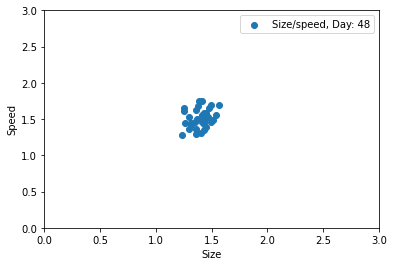

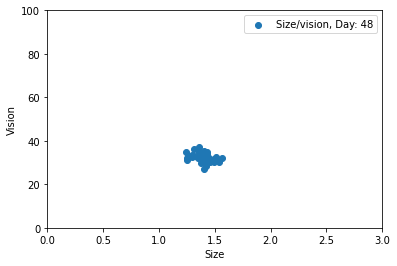

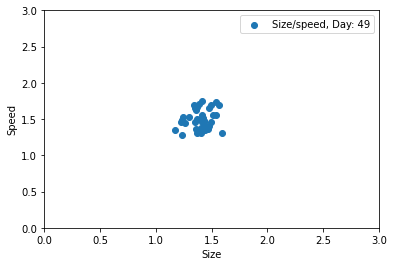

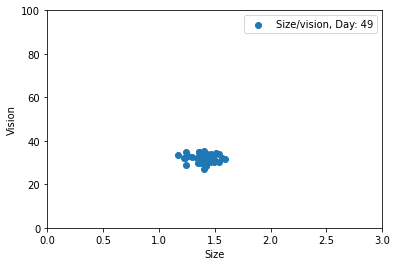

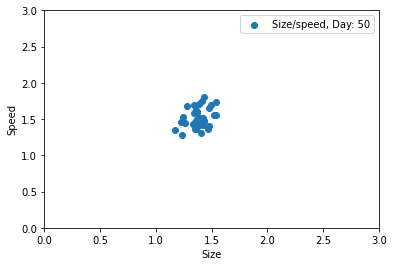

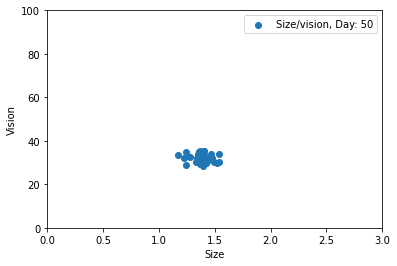

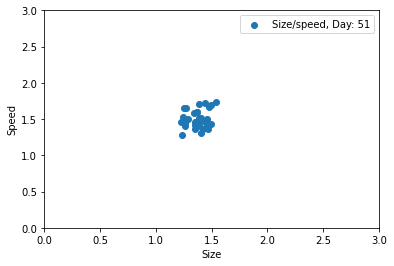

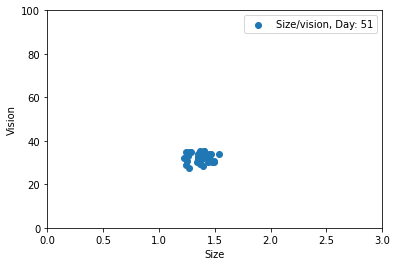

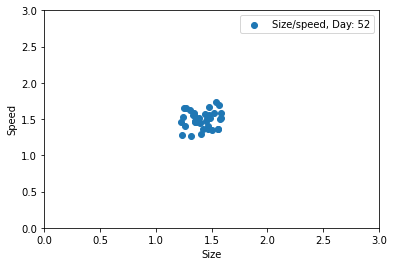

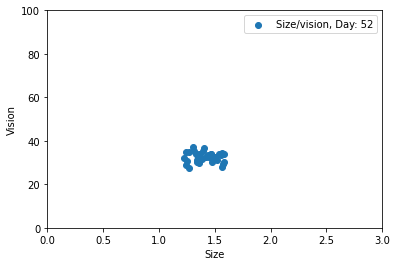

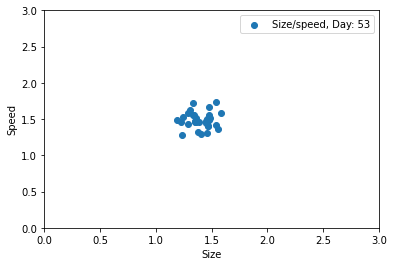

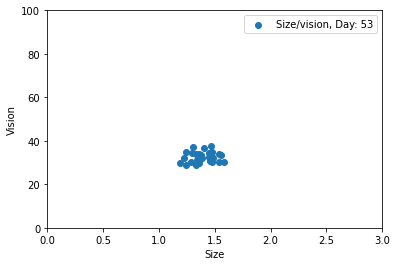

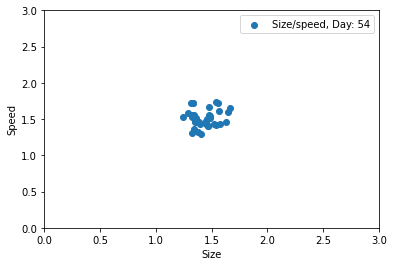

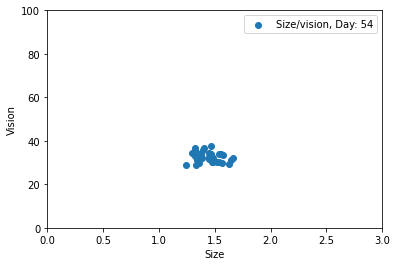

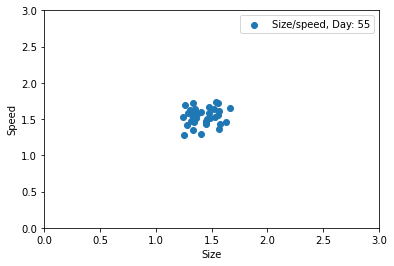

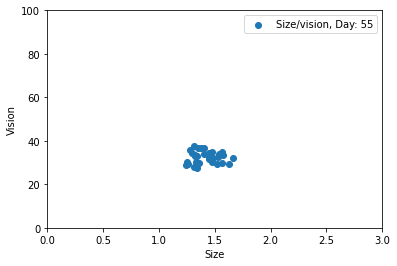

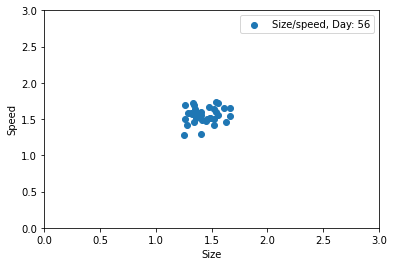

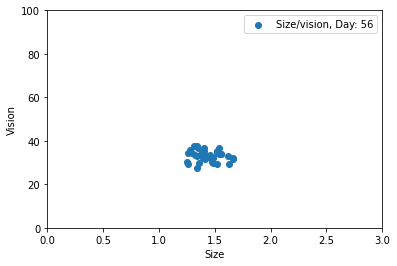

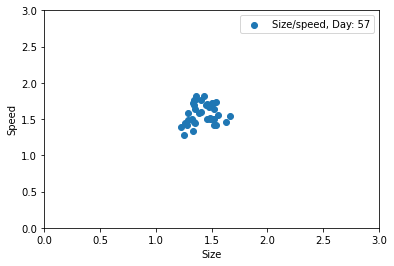

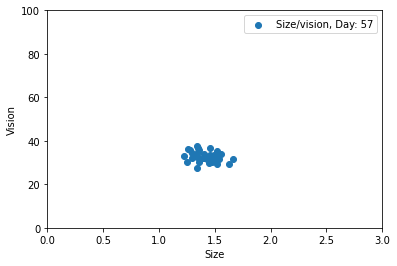

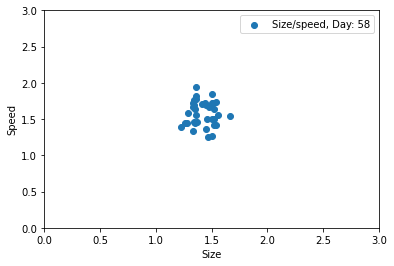

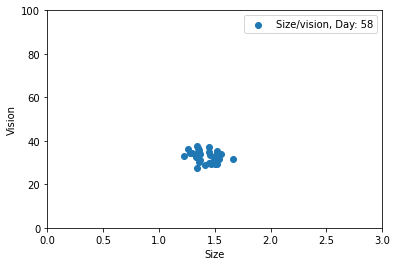

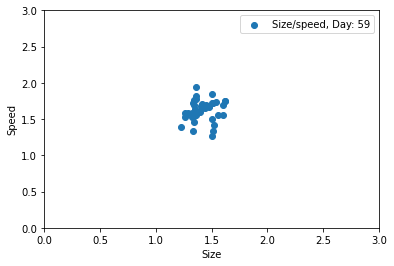

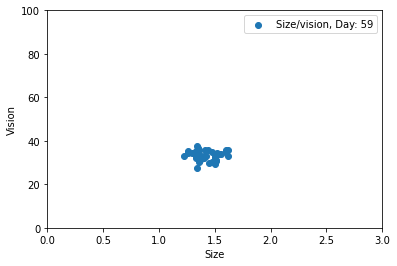

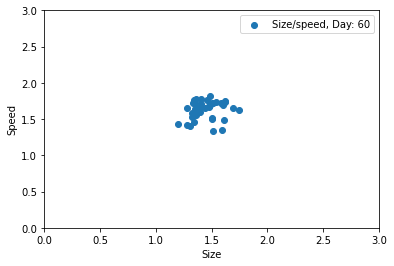

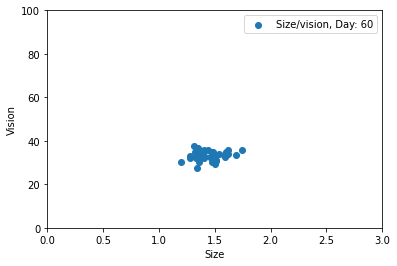

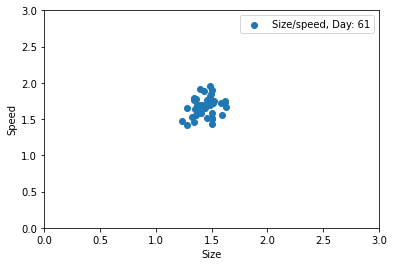

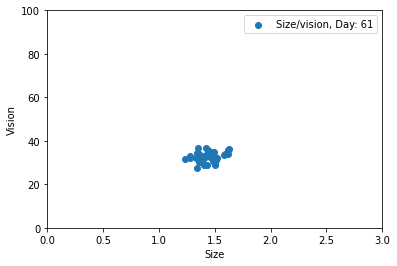

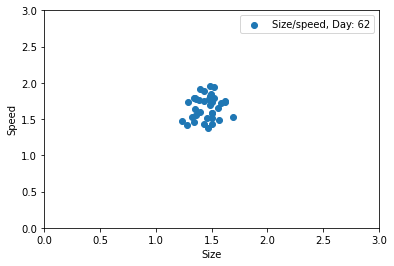

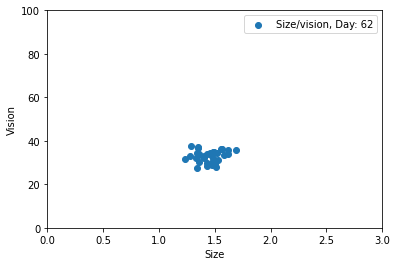

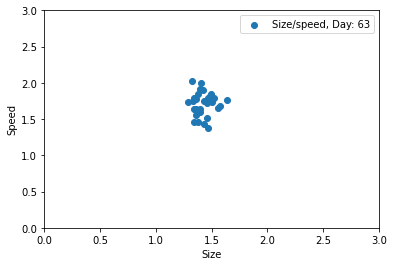

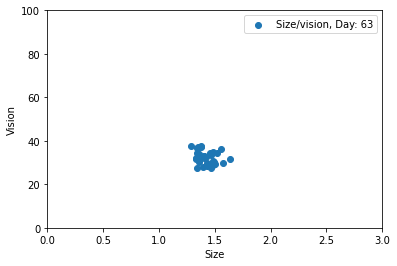

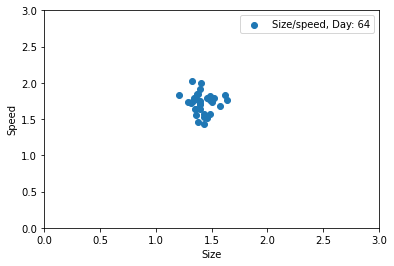

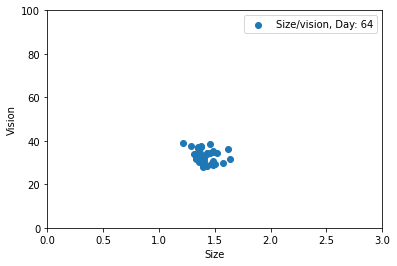

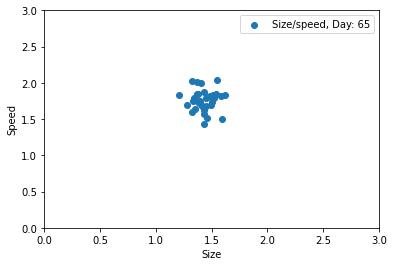

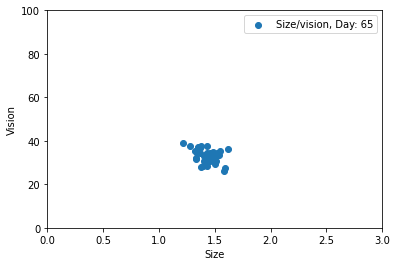

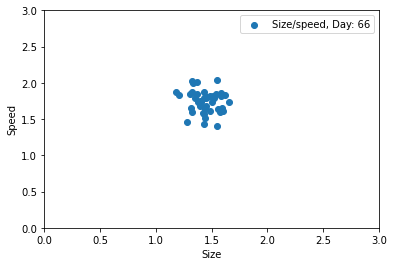

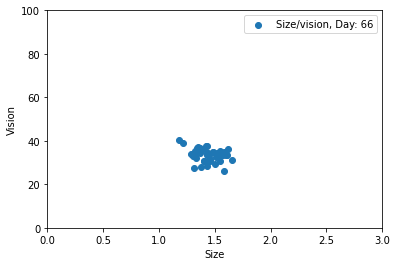

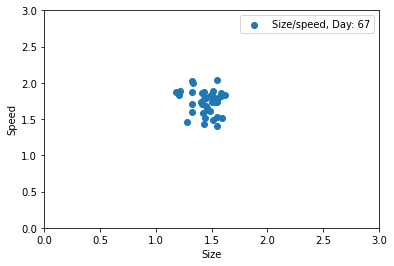

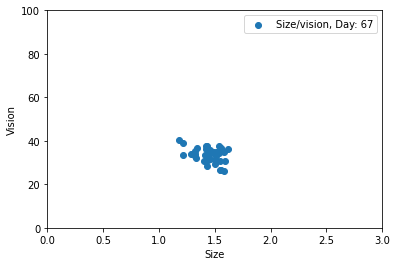

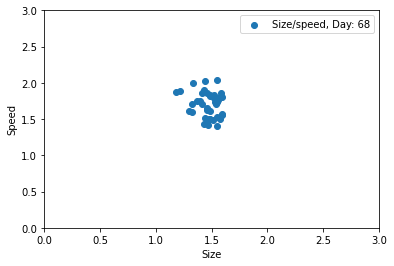

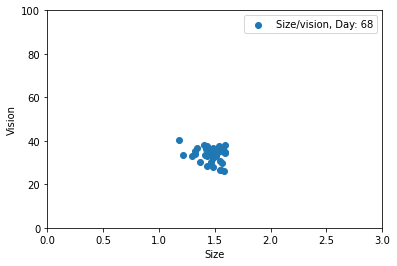

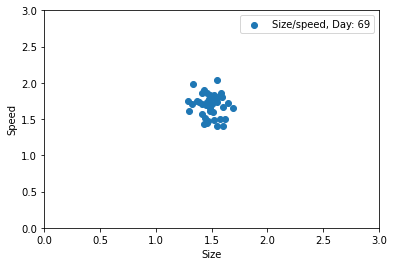

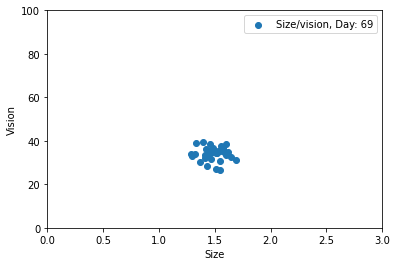

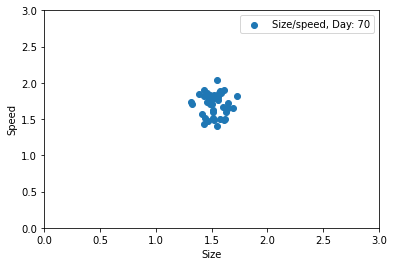

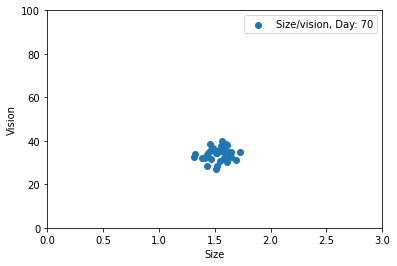

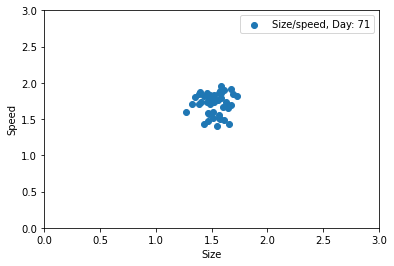

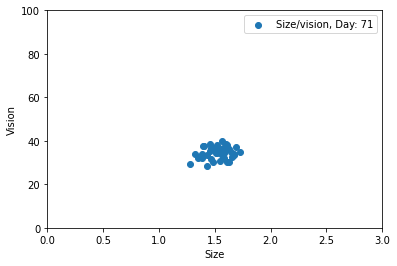

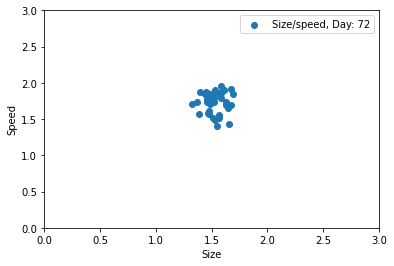

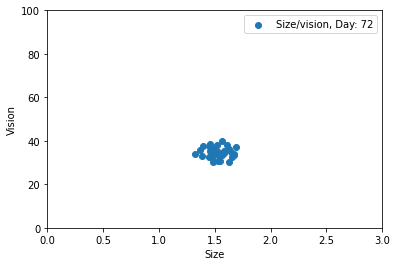

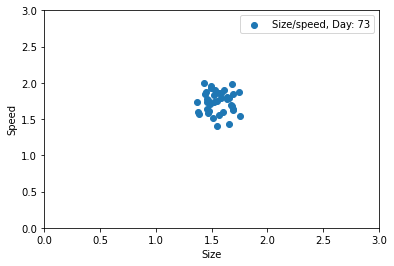

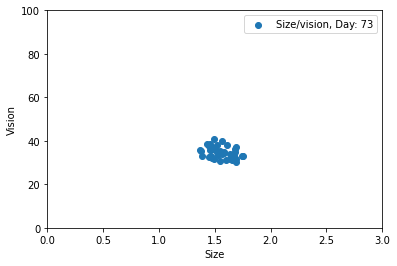

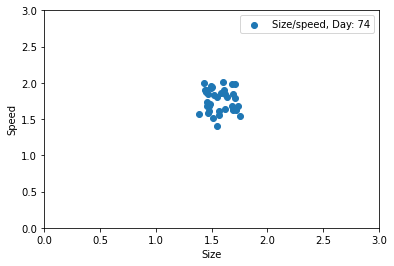

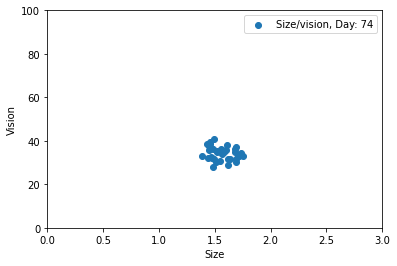

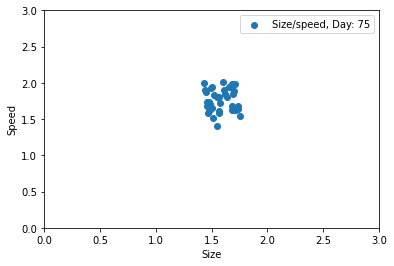

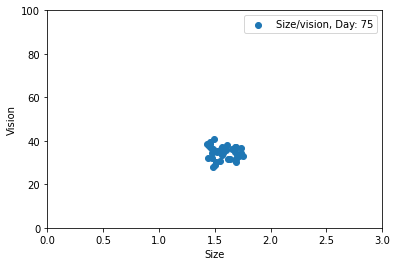

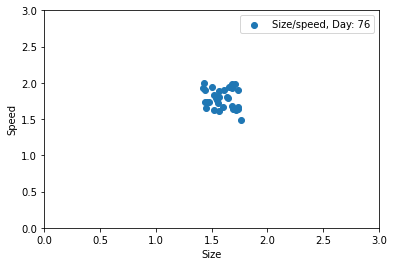

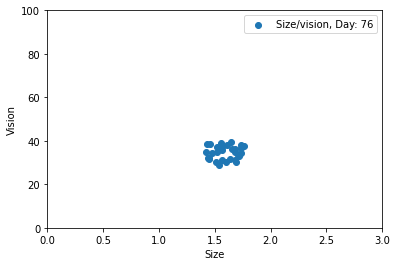

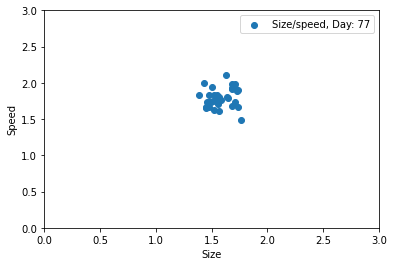

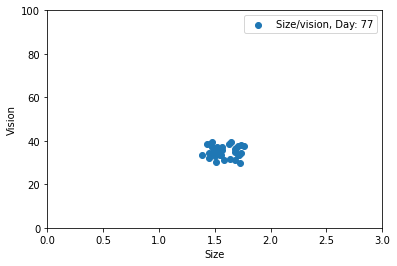

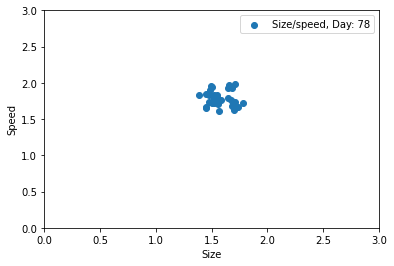

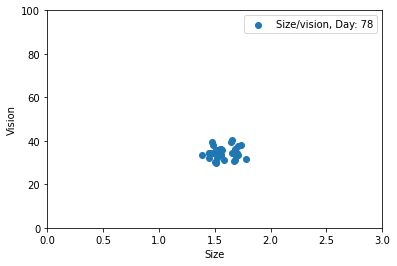

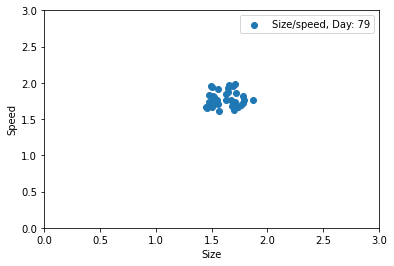

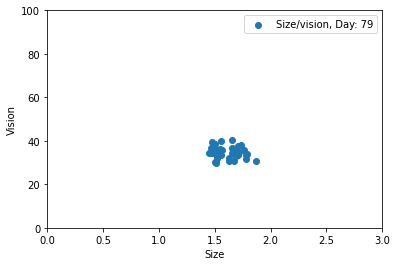

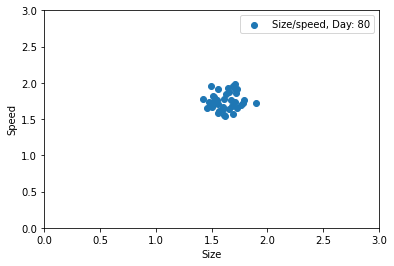

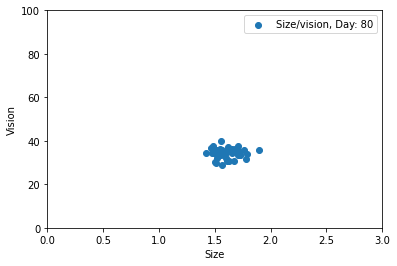

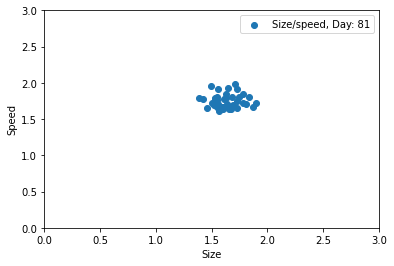

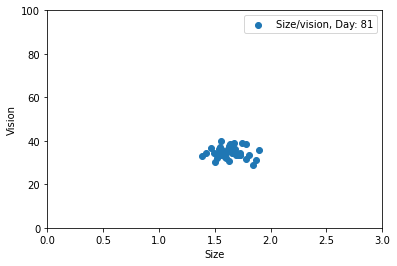

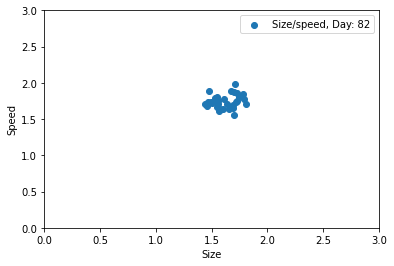

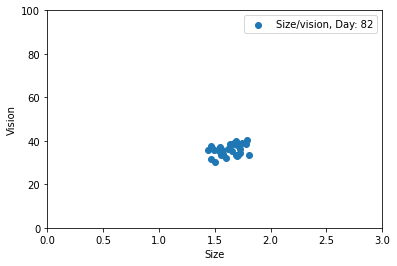

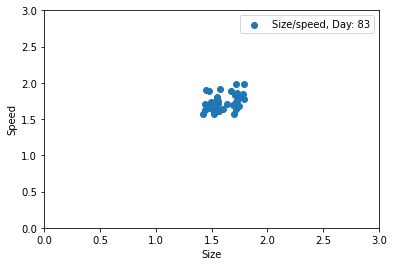

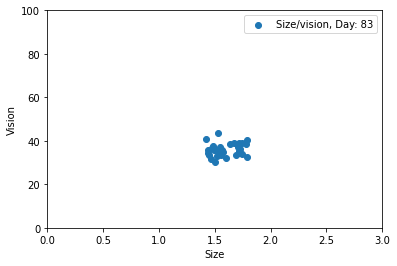

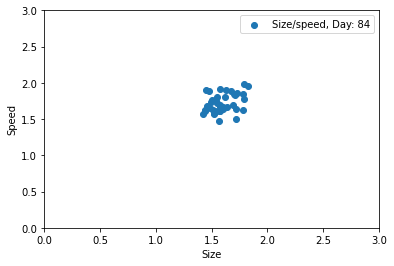

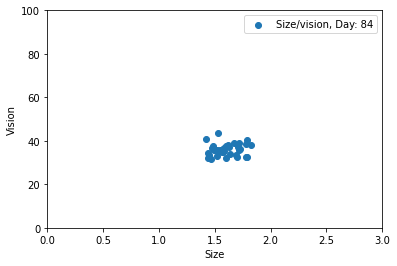

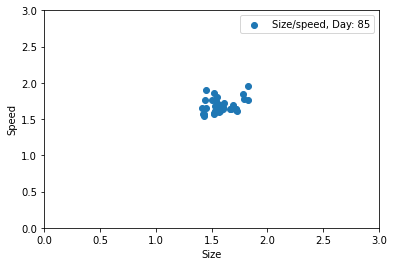

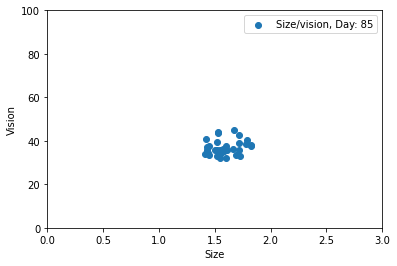

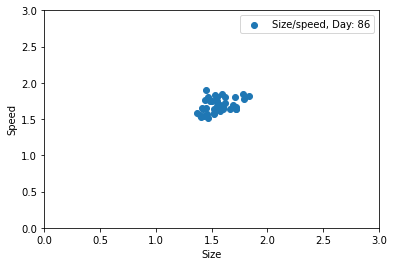

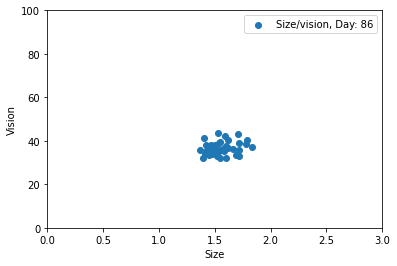

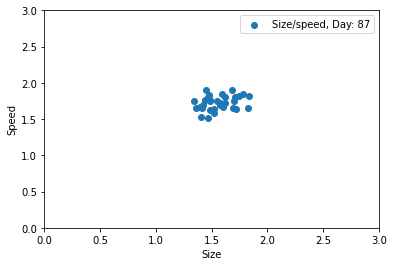

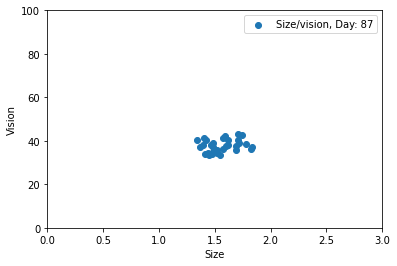

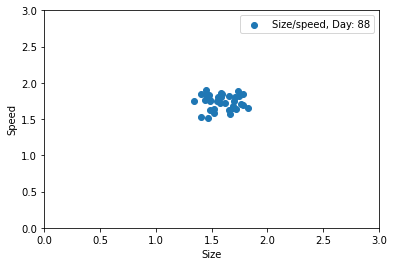

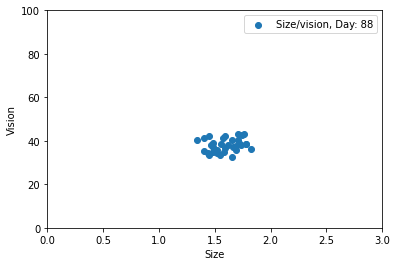

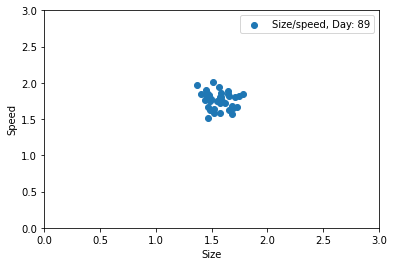

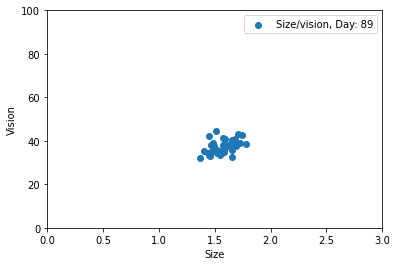

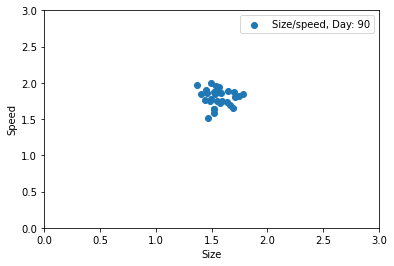

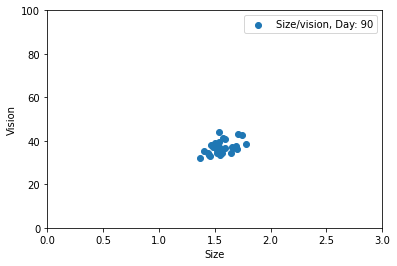

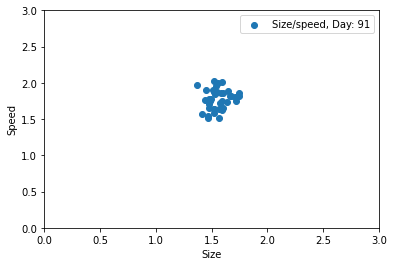

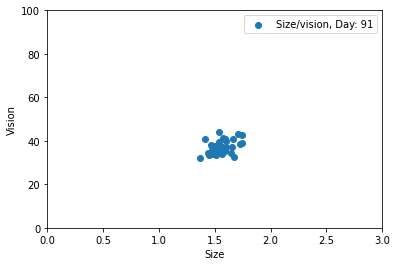

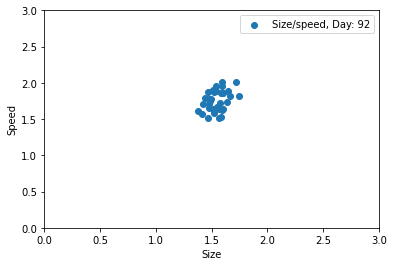

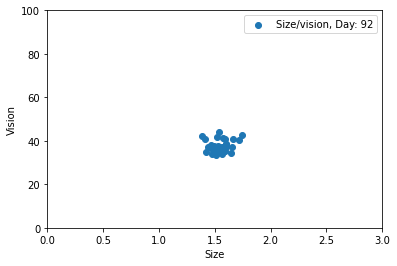

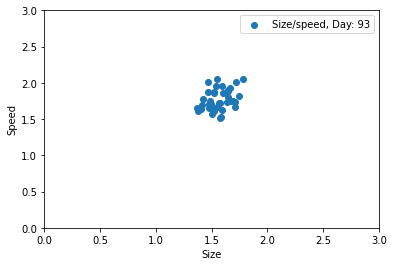

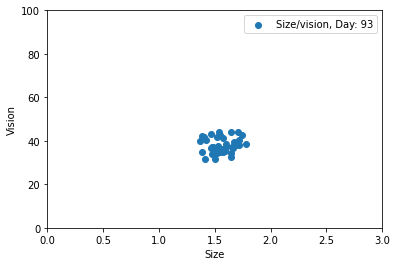

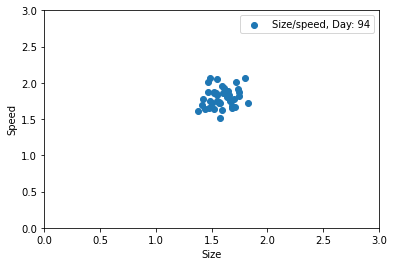

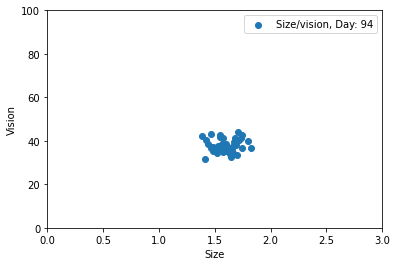

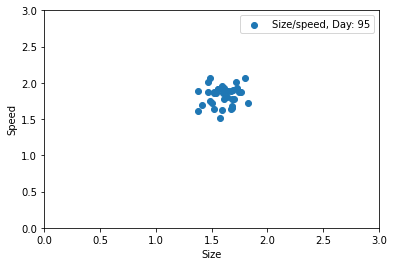

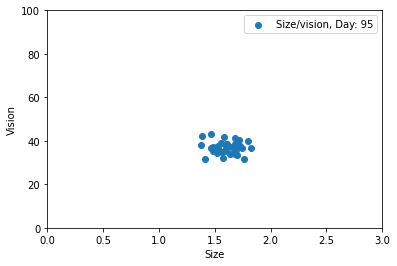

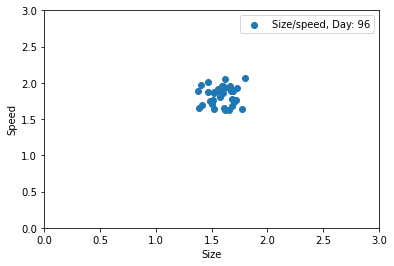

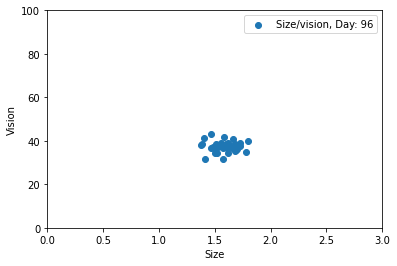

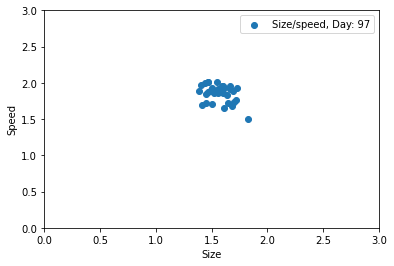

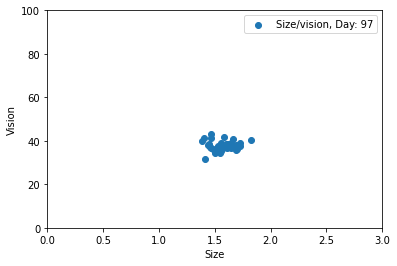

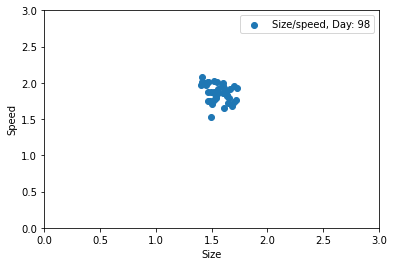

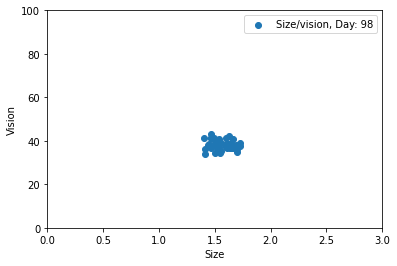

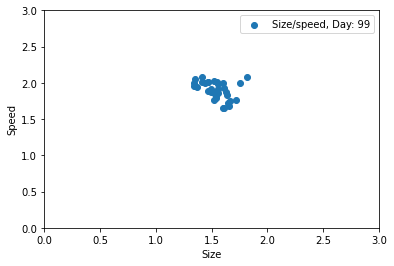

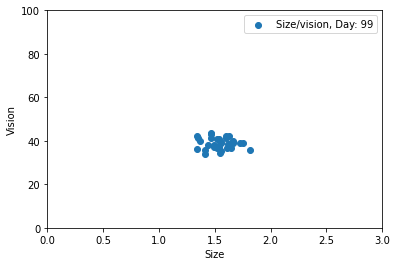

In [51]:
days=range(0,100)
jpg_files_paths="plots/"
for day in days:
    plt.figure()
    plt.scatter(size[day],speed[day],label="Size/speed, Day: "+str(day))
    plt.xlabel("Size")
    plt.ylabel("Speed")
    plt.xlim(0,3)
    plt.ylim(0,3)
    plt.legend()
    if day<10:
        plt.savefig("plots/size_speed00"+str(day)+".jpg")
    elif day<100:
        plt.savefig("plots/size_speed0"+str(day)+".jpg")
    else:
        plt.savefig("plots/size_speed"+str(day)+".jpg")

    plt.figure()
    plt.scatter(size[day],vision[day],label="Size/vision, Day: "+str(day))
    plt.xlabel("Size")
    plt.ylabel("Vision")
    plt.xlim(0,3)
    plt.ylim(0,100)
    plt.legend()
    if day<10:
        plt.savefig("plots/size_vision00"+str(day)+".jpg")
    elif day<100:
        plt.savefig("plots/size_vision0"+str(day)+".jpg")
    else:
        plt.savefig("plots/size_vision"+str(day)+".jpg")

In [55]:
max_days=days[-1]
images=[]
for image_path in sorted(glob.glob("plots/size_vision*.jpg")):
    images.append(imageio.imread(image_path))
imageio.mimsave("size_vision_"+str(max_days)+".gif",images)
images=[]
for image_path in sorted(glob.glob("plots/size_speed*.jpg")):
    images.append(imageio.imread(image_path))
imageio.mimsave("size_speed_"+str(max_days)+".gif",images)

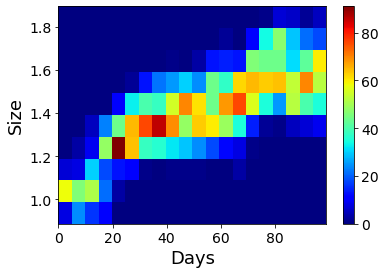

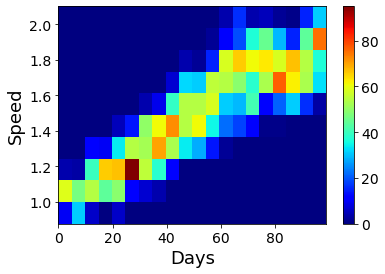

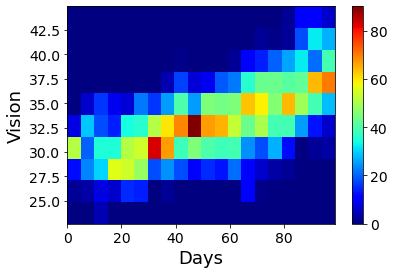

In [58]:
save=True
size_flatten=[]
speed_flatten=[]
vision_flatten=[]
days_flatten=[]
day=0
for size_arr,speed_arr,vision_arr in zip(size,speed,vision):
    for s,sp,v in zip(size_arr,speed_arr,vision_arr):
        size_flatten.append(s)
        speed_flatten.append(sp)
        vision_flatten.append(v)
        days_flatten.append(day)
    day +=1
fontsize_major=18
fontsize_minor=14
plt.figure()
plt.hist2d(days_flatten,size_flatten,bins=(20,10),cmap='jet')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize_minor)
plt.xlabel("Days",fontsize=fontsize_major)
plt.ylabel("Size",fontsize=fontsize_major)
plt.xticks(fontsize=fontsize_minor)
plt.yticks(fontsize=fontsize_minor)
if save:
    plt.savefig("figures_for_report/size_hist2d.png",bbox_inches='tight')

plt.figure()
plt.hist2d(days_flatten,speed_flatten,bins=(20,10),cmap='jet')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize_minor)
plt.xlabel("Days",fontsize=fontsize_major)
plt.ylabel("Speed",fontsize=fontsize_major)
plt.xticks(fontsize=fontsize_minor)
plt.yticks(fontsize=fontsize_minor)
if save:
    plt.savefig("figures_for_report/speed_hist2d.png",bbox_inches='tight')

plt.figure()
plt.hist2d(days_flatten,vision_flatten,bins=(20,10),cmap='jet')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize_minor)
plt.xlabel("Days",fontsize=fontsize_major)
plt.ylabel("Vision",fontsize=fontsize_major)
plt.xticks(fontsize=fontsize_minor)
plt.yticks(fontsize=fontsize_minor)
if save:
    plt.savefig("figures_for_report/vision_hist2d.png",bbox_inches='tight')

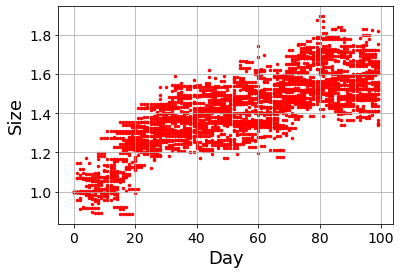

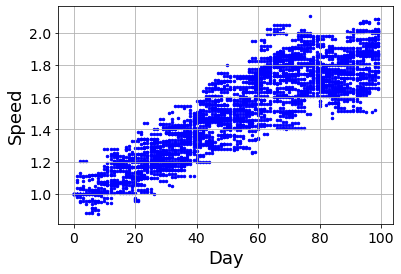

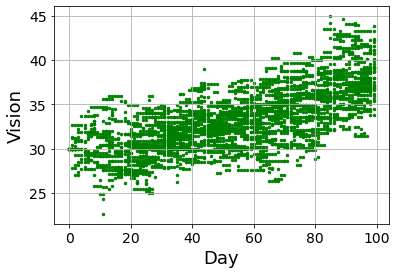

In [64]:
from matplotlib.ticker import MaxNLocator
save=True

fontsize_major=18
fontsize_minor=14

plt.figure()
plt.xlabel("Day",fontsize=fontsize_major)
plt.ylabel("Size",fontsize=fontsize_major)
plt.xticks(fontsize=fontsize_minor)
plt.yticks(fontsize=fontsize_minor)
plt.grid()
for day,s in zip(days,size):
    plt.scatter([day]*len(s),s,c="r",s=6)
if save:
    plt.savefig("figures_for_report/"+"/size_hits.png",bbox_inches='tight')

plt.figure()
plt.xlabel("Day",fontsize=fontsize_major)
plt.ylabel("Speed",fontsize=fontsize_major)
plt.xticks(fontsize=fontsize_minor)
plt.yticks(fontsize=fontsize_minor)
plt.grid()
for day,s in zip(days,speed):
    plt.scatter([day]*len(s),s,c="b",s=6)
if save:
    plt.savefig("figures_for_report/"+"/speed_hits.png",bbox_inches='tight')
    
plt.figure()
plt.xlabel("Day",fontsize=fontsize_major)
plt.ylabel("Vision",fontsize=fontsize_major)
plt.xticks(fontsize=fontsize_minor)
plt.yticks(fontsize=fontsize_minor)
plt.grid()
for day,s in zip(days,vision):
    plt.scatter([day]*len(s),s,c="g",s=6)
if save:
    plt.savefig("figures_for_report/"+"/vision_hits.png",bbox_inches='tight')


In [ ]:
#########################################################################################################################

In [45]:
"""  With pygame window """ 
    
window = pygame.display.set_mode((500, 500))
world_width, world_height = window.get_size()
Time = pygame.time.Clock()

runTime_speed = 60
display_world = True

animal_world = EcoSystem(world_width, world_height)
iteration = 0
while True:
   # print(iteration)
    
    if display_world:
        i = 0
        
        for row in range(animal_world.eco_system.width_num):
            for col in range(animal_world.eco_system.height_num):
                pygame.draw.rect(window,animal_world.eco_system.color[i],
                                 (animal_world.eco_system.width_PortionSize * row,
                                 animal_world.eco_system.height_PortionSize * col,
                                 animal_world.eco_system.width_PortionSize,
                                 animal_world.eco_system.height_PortionSize))
                i += 1
                
        [ window.blit(obj.Image, (obj.x, obj.y)) for obj in animal_world.system_objects ]
        
       
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_q:
                pygame.quit()
    
                
    animal_world.update(iteration)
    Day = "Day: "+ f"{int(iteration/1000 + 1)}"
    pygame.display.set_caption(Day)
    pygame.display.update()
    iteration += 1
    
   # Time.tick(runTime_speed)


error: video system not initialized